In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from models import MCDropout, AnchoredNetwork

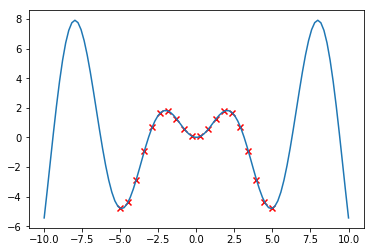

In [2]:
def f(x):
    return x * np.sin(x)

X = np.linspace(-5, 5, 20)
y = f(X)

line = np.linspace(-10, 10, 100)
y_line = f(line)

plt.plot(line, y_line)
plt.scatter(X, y, c='r', marker='x')

In [3]:
dataloader = DataLoader(TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float()))

## Monte Carlo Dropout

In [4]:
l = 1e-2
p_drop = 0.2
N = len(X)
tau = 2

weight_decay = (l**2 * (1 - p_drop)) / (2 * N * tau)

In [5]:
n_epoch = 2000
model = MCDropout(n_layers=[1, 20, 20, 1], p=p_drop)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

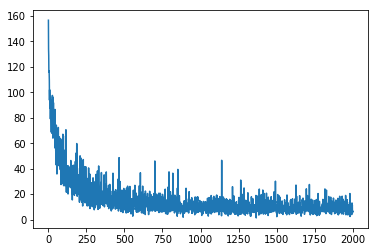

In [6]:
losses = []

for epoch in range(1, n_epoch + 1):
    batch_loss = 0
    
    for X_mb, y_mb in dataloader:
        y_pred = model(X_mb.reshape(-1, 1))
        loss = loss_fn(y_pred.squeeze(), y_mb)
        batch_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 100 == 0:
        print('epoch: {}/{}, loss={:.2f}'.format(epoch, n_epoch, batch_loss), end='\r')

    losses.append(batch_loss)
    
plt.plot(range(1, n_epoch + 1), losses)

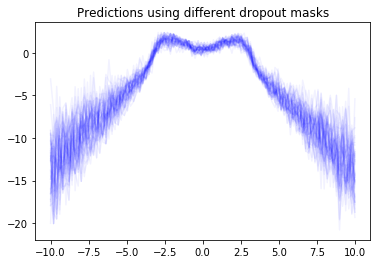

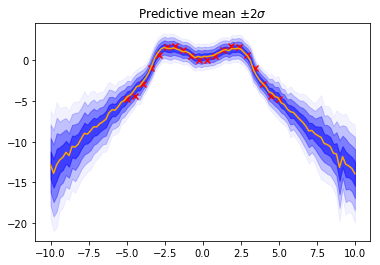

In [7]:
T = 50

with torch.no_grad():
    y_preds = torch.stack([model(torch.from_numpy(line).float().reshape(-1, 1)).squeeze() for _ in range(T)]).numpy()
    
    
plt.title('Predictions using different dropout masks')
for t in range(T):
    plt.plot(line, y_preds[t, :], c='blue', alpha=0.05)


pred_mean = np.mean(y_preds, axis=0)
pred_var = 1/tau + np.var(y_preds, axis=0)

std = np.sqrt(pred_var)

plt.figure()
plt.title('Predictive mean ±2$\sigma$')

alphas = np.linspace(0.05, 0.5, 4)
ds = reversed(np.linspace(0.5, 2, 4))

for alpha, d in zip(alphas, ds):
    plt.fill_between(line, pred_mean - d * std, pred_mean + d * std, alpha=alpha, color='blue')

plt.scatter(X, y, c='r', marker='x')
plt.plot(line, pred_mean, c='orange')

## Anchored Ensemble

In [8]:
n_epoch = 1000
n_ensemble = 10
lambda_anchor = 0.2
loss_fn = nn.MSELoss()

layers = [1, 20, 20, 1]

In [9]:
models = []

for i in range(n_ensemble):
    print('iter', i)
    
    model = AnchoredNetwork([1, 20, 20, 1], 0.5, 1)
    optimizer = torch.optim.Adam(model.parameters())

    losses = []

    for epoch in range(1, n_epoch + 1):
        batch_loss = 0

        for X_mb, y_mb in dataloader:
            y_pred = model(X_mb.reshape(-1, 1))

            loss = loss_fn(y_pred.squeeze(), y_mb) + lambda_anchor / len(y_mb) * model.get_weight_diff()
            batch_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

#         if epoch % 100 == 0:
#             print('epoch: {}/{}, loss={:.2f}'.format(epoch, n_epoch, batch_loss), end='\r')

        losses.append(batch_loss)

    models.append(model)

iter 0
iter 1
iter 2
iter 3
iter 4
iter 5
iter 6
iter 7
iter 8
iter 9


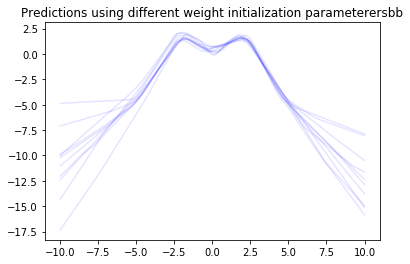

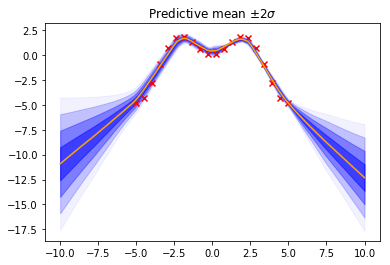

In [10]:
with torch.no_grad():
    x = torch.from_numpy(line).float().reshape(-1, 1)
    y_preds = torch.stack([model(x).squeeze() for model in models]).numpy()
    
pred_mean = np.mean(y_preds, axis=0)
pred_var = np.var(y_preds, axis=0)

plt.title('Predictions using different weight initialization parameterersbb')
for t in range(len(models)):
    plt.plot(line, y_preds[t, :], c='blue', alpha=0.1)

std = np.sqrt(pred_var)

plt.figure()
plt.title('Predictive mean ±2$\sigma$')

alphas = np.linspace(0.05, 0.5, 4)
ds = reversed(np.linspace(0.5, 2, 4))

for alpha, d in zip(alphas, ds):
    plt.fill_between(line, pred_mean - d * std, pred_mean + d * std, alpha=alpha, color='blue')

plt.scatter(X, y, c='r', marker='x')
plt.plot(line, pred_mean, c='orange')